<a id='top'></a>
# Schools, Hospitals & House Prices in the DC Metro Area

#### Contributors: Muoyo Okome, VJ Paravastu


<a id='toc'></a>
### Table of Contents
1. <a href='#problemstatement'>Problem Statement</a>
2. <a href='#datasources'>Data Sources</a>
3. <a href='#datacleaning'>Data Cleaning</a>
4. <a href='#hypothesistests'>Hypothesis Tests</a>
5. <a href='#findings'>Findings</a>
6. <a href='#nextsteps'>Next Steps</a>

In [2]:
# Import necessary libraries
import warnings
import pandas as pd
from scipy import stats
from statsmodels.stats.weightstats import ztest
warnings.filterwarnings('ignore')

<a id='problemstatement'></a>
### Problem Statement

The goal of this analysis is to better understand house prices in the DC Metro Area, and some of the factors that may affect them, viewed at the county level. 

Specifically we looked at the median house price in each county, the number of hospitals per county, the number of public schools per county, and the number of private schools per county. We also examined how these variables differed in subsets of the poplulation with lower house prices vs higher house prices.

<a href='#top'>Back to Top ↑</a>

<a id='datasources'></a>
### Data Sources

#### <b><a href='https://www.zillow.com/research/data/'>Zillow Home Value Index</a></b>

- Housing

#### <b><a href='https://hifld-geoplatform.opendata.arcgis.com/'>HIFLD Open Data</a></b>

- Public Schools

- Private Schools

- Hospitals

#### <b><a href='https://www2.census.gov'>US Census Bureau</a></b>

- Population Data
<br> 

<a href='#top'>Back to Top ↑</a>

<a id='datacleaning'></a>
### Data Cleaning

In [169]:
# Read in original data
df_housing = pd.read_csv('../data/County_Zhvi_AllHomes.csv', encoding='latin1')
df_public_schools = pd.read_csv('../data/Public_Schools.csv')
df_private_schools = pd.read_csv('../data/Private_Schools.csv')
df_hospitals = pd.read_csv('../data/Hospitals.csv')
df_population = pd.read_csv('../data/PEP_2018_PEPANNRES_with_ann.csv', encoding='latin1')

In [4]:
# Clean data & load into final dataframe
%run ../python_files/data_cleaning

In [47]:
df_dcmetro_final = clean_data(df_housing, df_public_schools, df_private_schools, df_hospitals, df_population)

In [187]:
# Import python files we've created to help
%run ../python_files/utils
%run ../python_files/hypothesis_tests
%run ../python_files/visualizations

# Additional calculations about DC Metro Counties to be used for tests & visualizations
dcmi = DCMetroInfo(df_dcmetro_final)



<a href='#top'>Back to Top ↑</a>

<a id='hypothesistests'></a>
### Hypothesis Tests

In [174]:
# Chi Square Test - p value = 0.0330062576612325

chi2_contingency([[ len(dcmi.high_price_low_pct_private_schools), len(dcmi.high_price_high_pct_private_schools) ],
                  [ len(dcmi.low_price_low_pct_private_schools), len(dcmi.low_price_high_pct_private_schools) ]])

(4.545454545454546, 0.0330062576612325, 1, array([[5.5, 5.5],
        [5.5, 5.5]]))

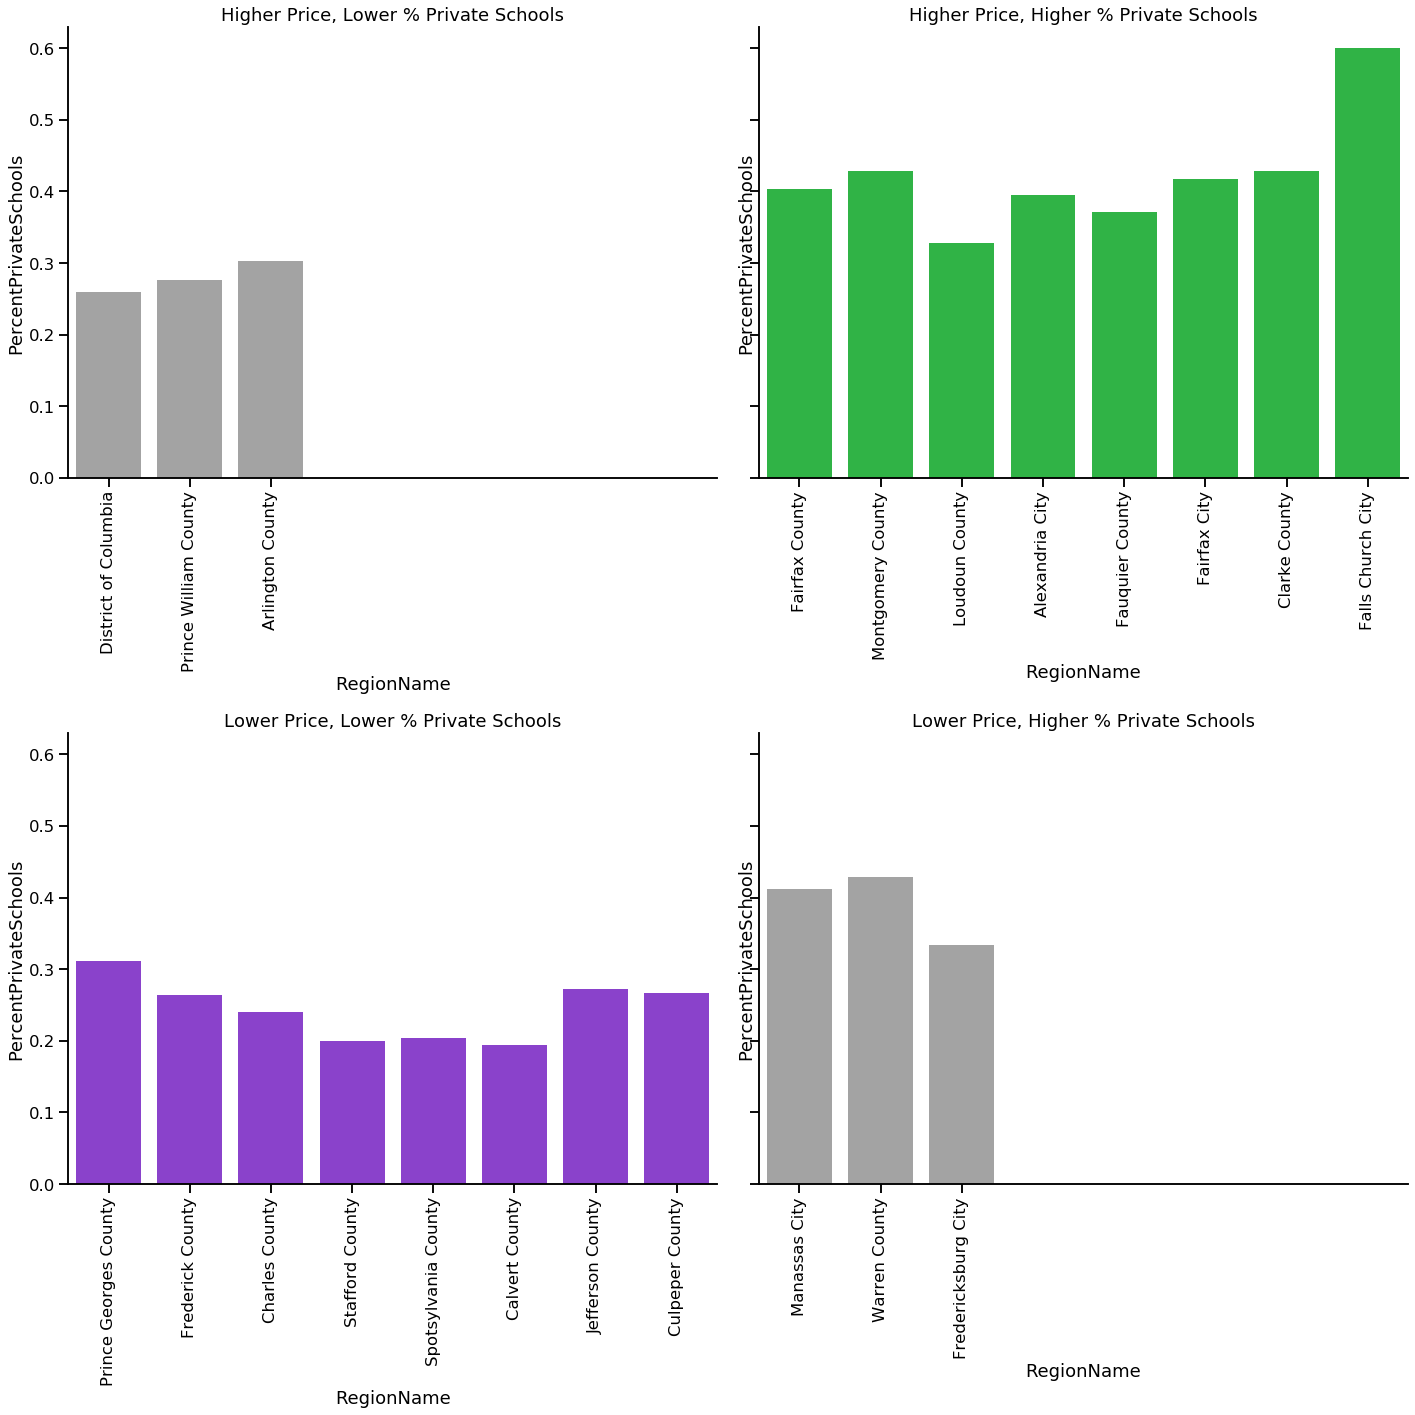

In [188]:
barplots_2x2_matrix(dcmi, 'RegionName', 'PercentPrivateSchools');

In [189]:
# Z tests comparing counties with lower house prices to counties with higher house prices

In [190]:
ztest (dcmi.low_price_counties['PeoplePerHospital'], dcmi.high_price_counties['PeoplePerHospital'])

(0.2676751711328554, 0.7889493631674214)

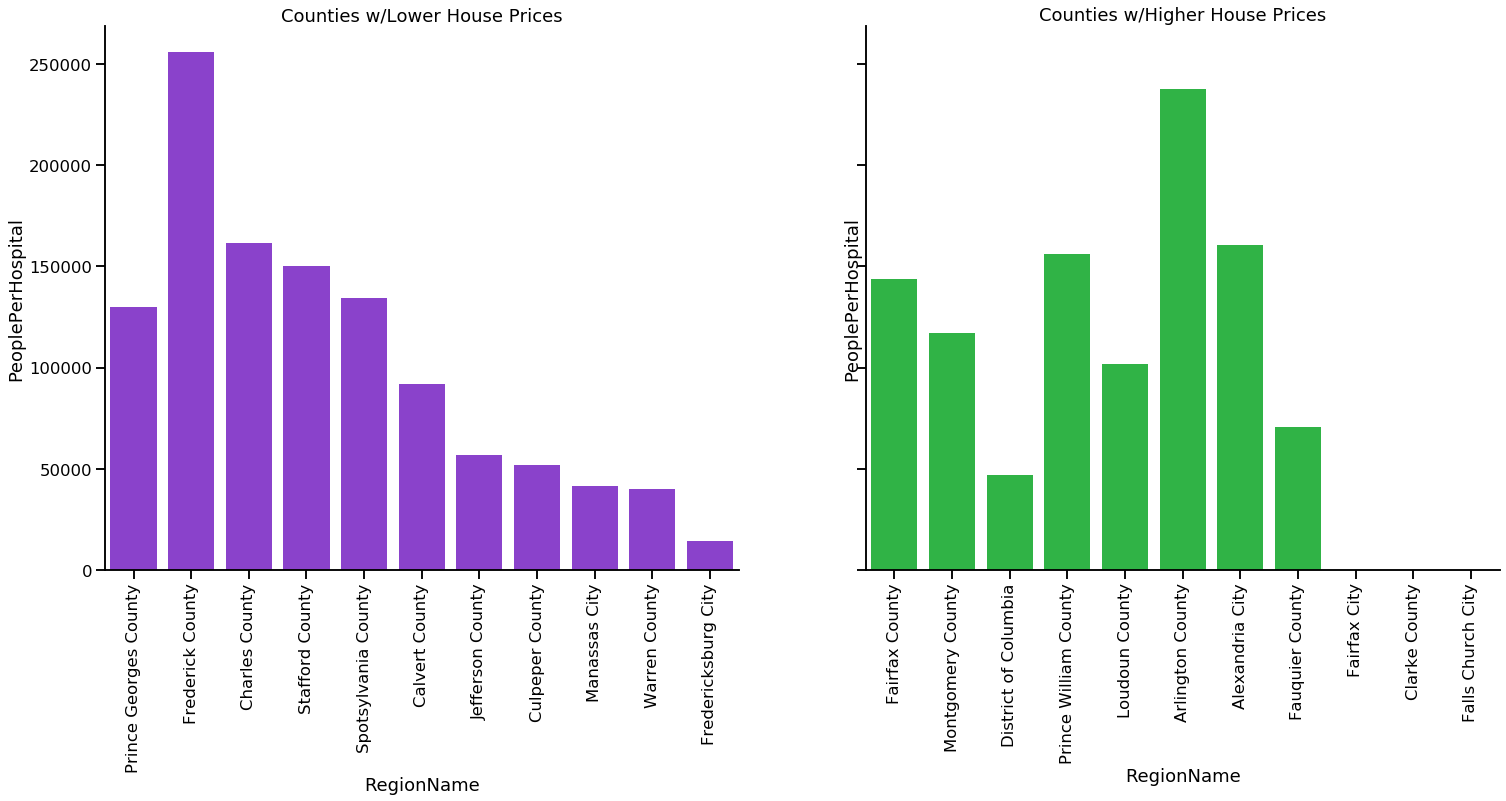

In [191]:
barplots_side_by_side(dcmi, 'RegionName', 'PeoplePerHospital', 'Counties w/Lower House Prices', 'Counties w/Higher House Prices');

In [192]:
ztest (dcmi.low_price_counties['PeoplePerSchool'], dcmi.high_price_counties['PeoplePerSchool'])

(0.41487340816509116, 0.6782345773522396)

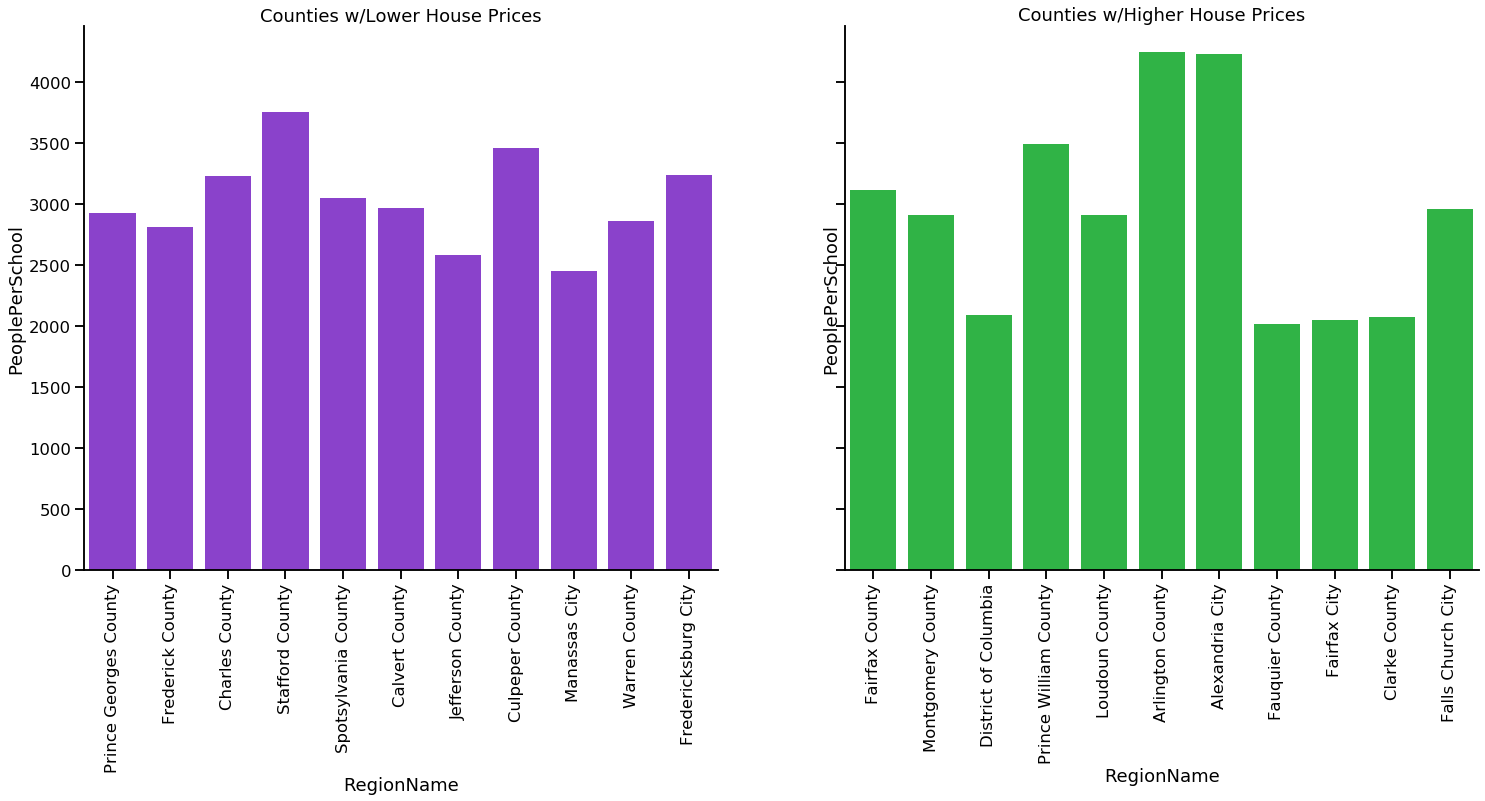

In [193]:
barplots_side_by_side(dcmi, 'RegionName', 'PeoplePerSchool', 'Counties w/Lower House Prices', 'Counties w/Higher House Prices');

In [194]:
ztest (dcmi.low_price_counties['PercentPrivateSchools'], dcmi.high_price_counties['PercentPrivateSchools'])

(-2.6318370223362892, 0.008492459061615488)

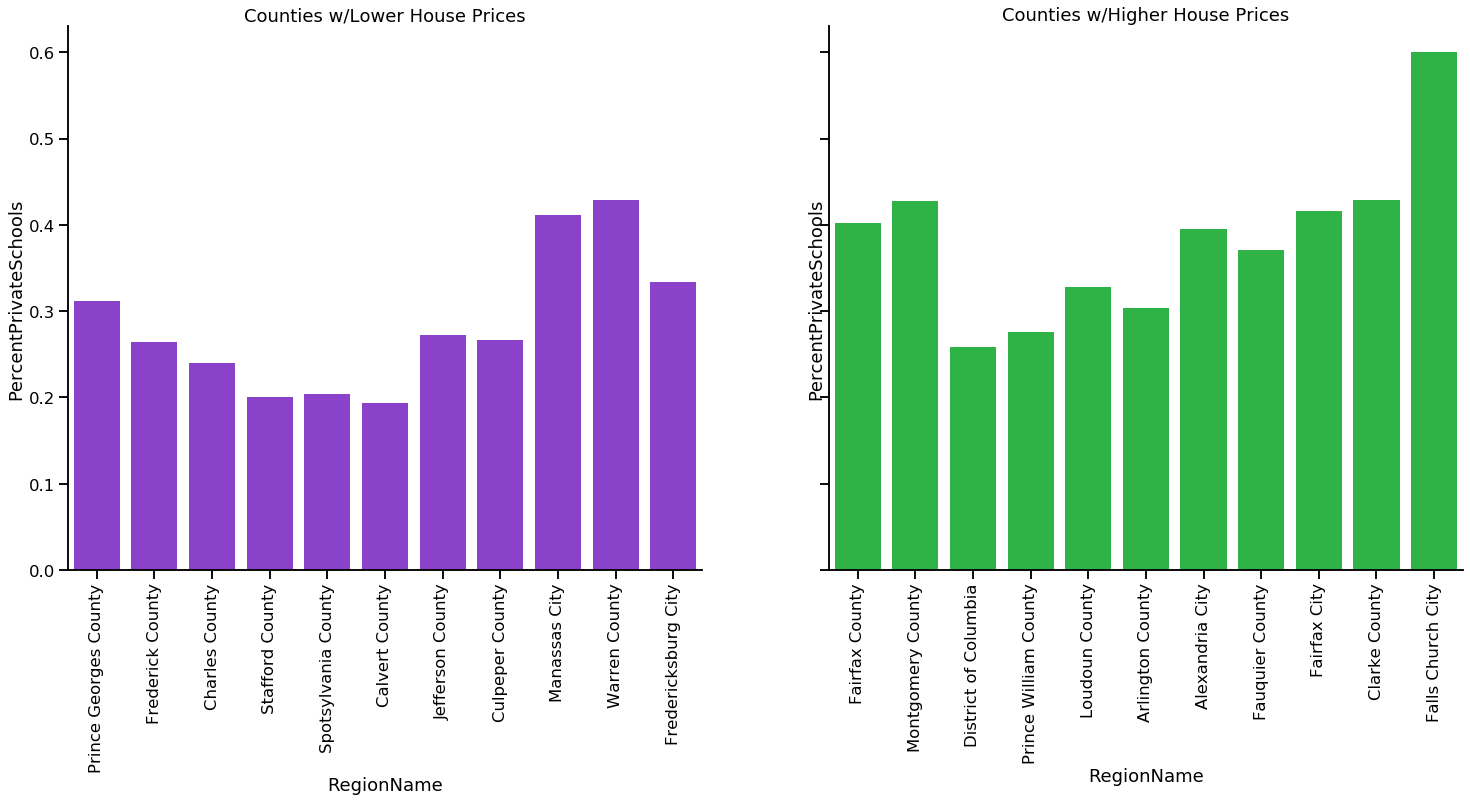

In [195]:
barplots_side_by_side(dcmi, 'RegionName', 'PercentPrivateSchools', 'Counties w/Lower House Prices', 'Counties w/Higher House Prices');

In [196]:
ztest (dcmi.low_price_counties['NumberOfPrivateSchools'] / dcmi.low_price_counties['Population'], 
       dcmi.high_price_counties['NumberOfPrivateSchools'] / dcmi.high_price_counties['Population'])

(-2.372554466283912, 0.017665558355976503)

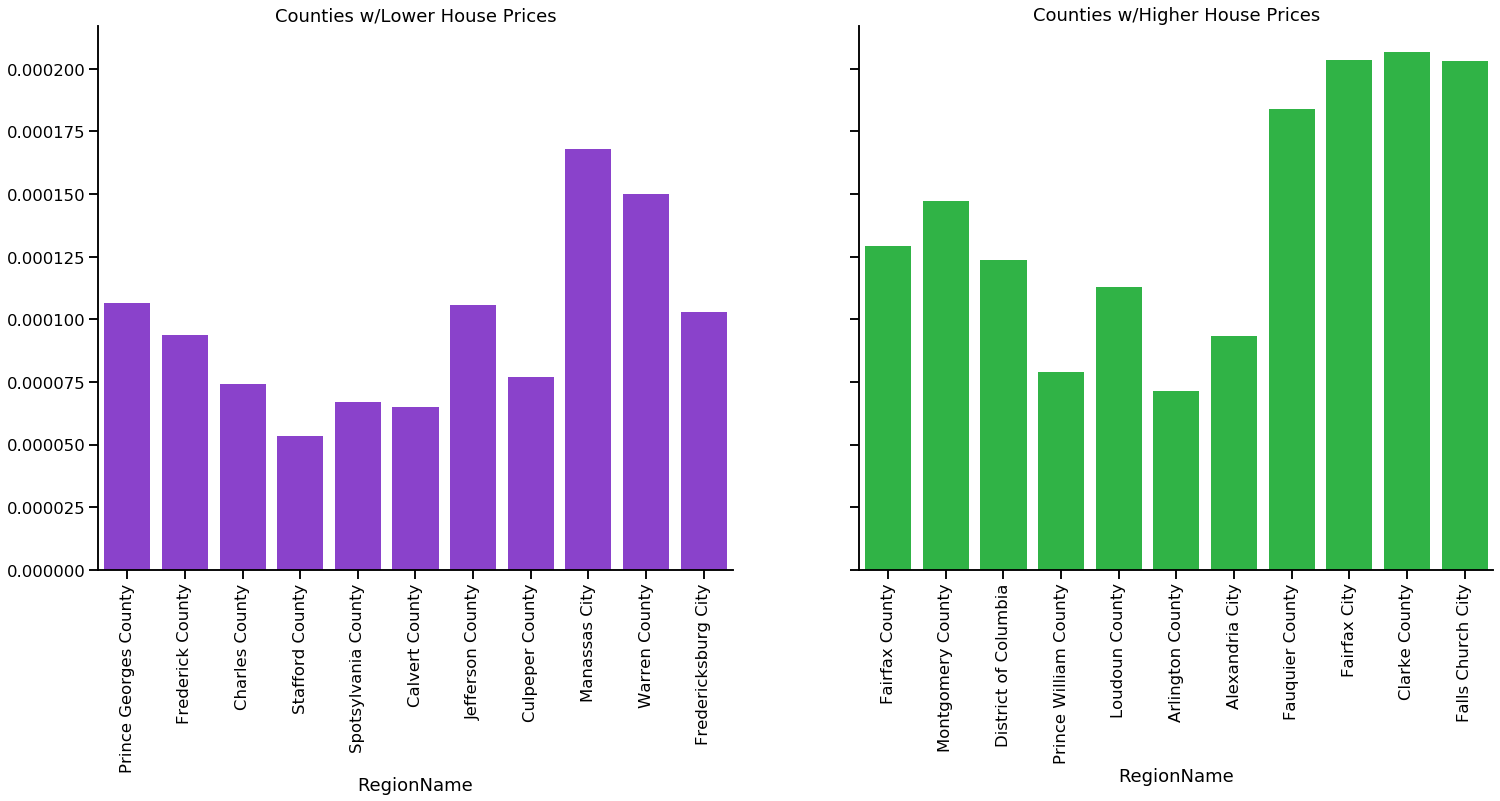

In [197]:
barplots_side_by_side_proportion(dcmi, 'RegionName', 'NumberOfPrivateSchools', 'Population', 'Counties w/Lower House Prices', 'Counties w/Higher House Prices');

In [198]:
ztest (dcmi.low_price_counties['NumberOfPublicSchools'] / dcmi.low_price_counties['Population'], 
       dcmi.high_price_counties['NumberOfPublicSchools'] / dcmi.high_price_counties['Population'])

(0.4811415006000532, 0.6304159343470777)

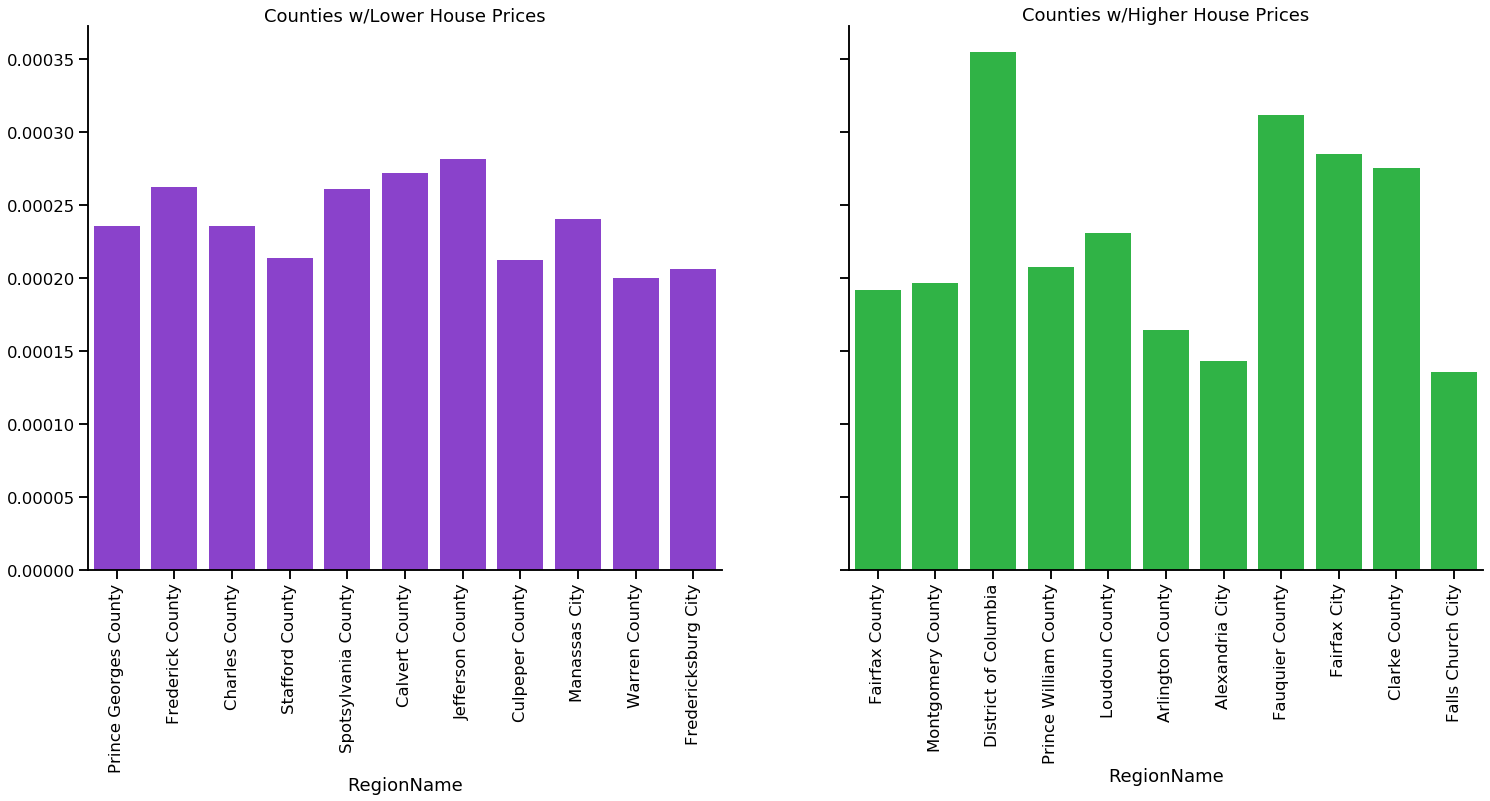

In [199]:
barplots_side_by_side_proportion(dcmi, 'RegionName', 'NumberOfPublicSchools', 'Population', 'Counties w/Lower House Prices', 'Counties w/Higher House Prices');

<p></p>
<p></p>
<p></p>
   

<a href='#top'>Back to Top ↑</a>

<p></p>
<p></p>
<p></p>

<a id='findings'></a>
### Findings

#### <b>Statistically significant findings:</b>

- Counties with higher house prices have more private schools per person

- Counties with higher house prices have a higher % of private schools

#### <b>No clear relationship:</b>

- No clear relationship between house prices & number of hospitals

- No clear relationship between house prices & people per school

<a href='#top'>Back to Top ↑</a>

<a id='nextsteps'></a>
### Next Steps

1. Analyze factors that may help to predict house prices in the Washington DC metro area. 

2. Work with more granular data to enable insights on the neighborhood, zip code, and individual home level. 

3. Perform regression analysis to help identify relationships between factors and house prices.

<a href='#top'>Back to Top ↑</a>